In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import torch.nn.functional as F

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [2]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
len(words)


32033

In [4]:
#Creating dictionaries
alphabet = sorted(list(set(''.join(words))))
itos = {idx + 1: ch for idx, ch in enumerate(alphabet)} 
itos[0] = '.'
stoi = {s : i  for i, s in itos.items()} 


In [5]:
#Creating the dataset

block_size = 3
vocab_size = len(itos)
def create_dataset(words): 
    X = []
    Y = []
    for word in words:
        context = block_size * [0]

        for i in word + '.':
            idx = stoi[i]
            Y.append(idx)
            X.append(context)
            #print(f"{context} ---> {i}")
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = create_dataset(words[:n1])
Xdev, Ydev = create_dataset(words[n1:n2])
Xte, Yte = create_dataset(words[n2:])

print (Xtr.shape, Ytr.shape)    
print (Xdev.shape, Ydev.shape)
print (Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [102]:
#Declare parameters w1, w2, b1, b2
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),          generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g) / (5/3) / (block_size * n_embd) ** 0.5 
b1 = torch.randn(n_hidden,                                generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size,                    generator=g)  * 0.1 #it is multiply by 0.1 to get smaller logits and smaller loss
b2 = torch.randn(vocab_size,                              generator=g)  * 0 # it is declare as 0 for the model initialization

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters =  {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of parameters =  11897


     X  |  Mean = 0.0005, Std = 1.0 
 Logits |  Mean = -0.0014, Std = 0.6 


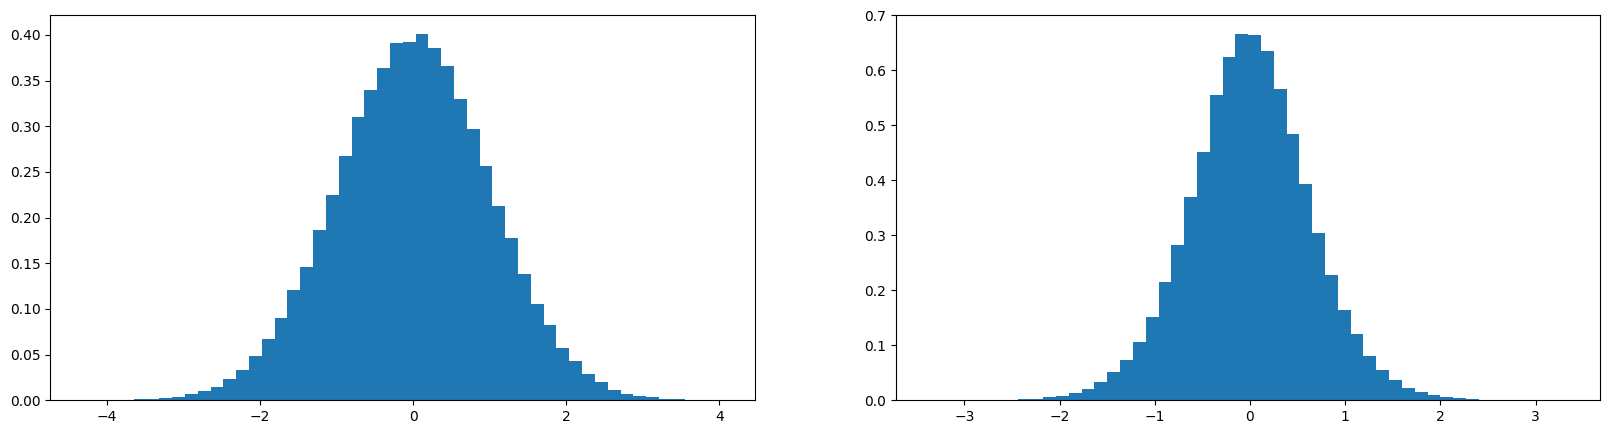

In [103]:
# This code demonstrates the effect of multiplying the input values (X) by the Weights tensor (W). 
# The result of this multiplication is a set of values (logits) with varying mean and standard deviation, depending on the values in W.
# The multiplication factor for W to achieve a specific mean and standard deviation for the logits is calculated as 5/3 / sqrt(n_embd).
# Adjusting the values in W (and thus the logits) is crucial in deep neural networks. 
# If the logits are too large or too small, it can make the model difficult to train.
X = torch.randn(10000, 10)
W = torch.randn(10, 20) * 0.2
Y = X @ W
print(f"     X  |  Mean = {X.mean():.4f}, Std = {X.std():.1f} ")
print(f" Logits |  Mean = {Y.mean():.4f}, Std = {Y.std():.1f} ")
plt.figure(figsize= (20, 5))
plt.subplot(121)
plt.hist(X.view(-1).tolist(), bins = 50, density=True);

plt.subplot(122)
plt.hist(Y.view(-1).tolist(), bins = 50, density=True);

In [104]:
#Execute the forward pass
batch_size = 32
loop = 200000

for _ in range(loop):
    #Batching
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y


    #Forward pass
    emb = C[Xb] #embed the characters into vector 
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    #Linear layer
    hpreact = embcat @ W1 
    #Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    #print(loss)

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

  # update
    lr = 0.1 if _ < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad
      
    if _ % 10000 == 0:    
        print(f"{loss=}")
      
    #break
    


loss=tensor(3.5715, grad_fn=<NllLossBackward0>)


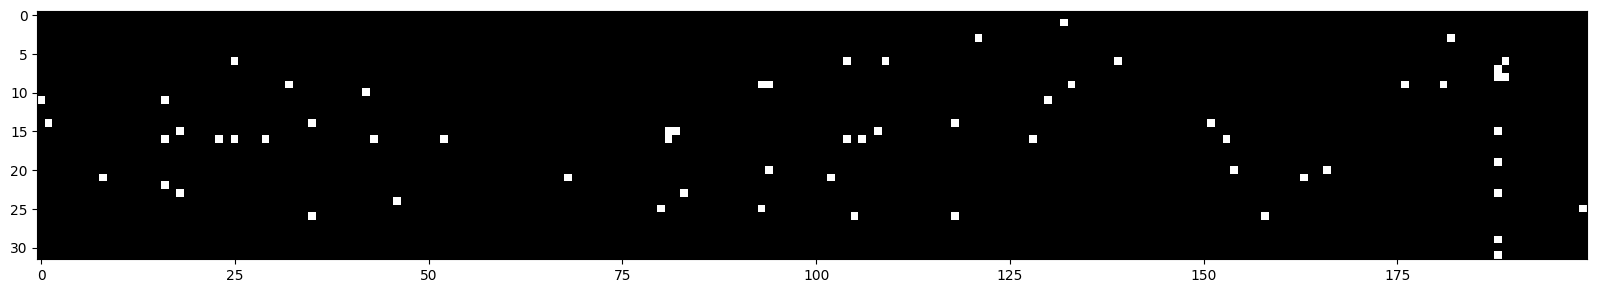

In [38]:
#Checking how many values in the h tensor are greater than 0.99
# I used abs value to consider -1 and +1 as the same value
# It was calculated becase one values in the h tensor don't help the backpropagation steps due to 1 values give us a gradient of 0 and it turn out to be a dead neuron
plt.figure(figsize=(20, 10))    
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

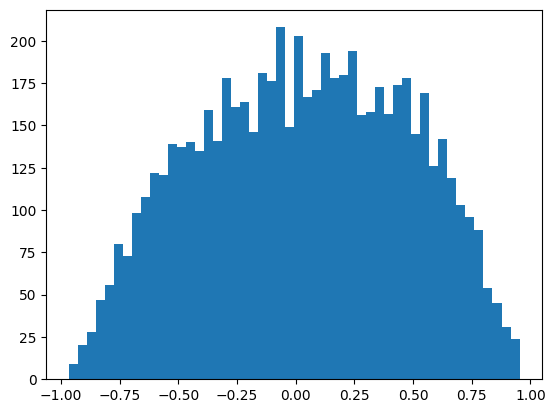

In [106]:
#Distribution of tanh results, if it has too many 1 or -1 values, it will be a dead neuron
plt.hist(h.view(-1).tolist(), bins=50);

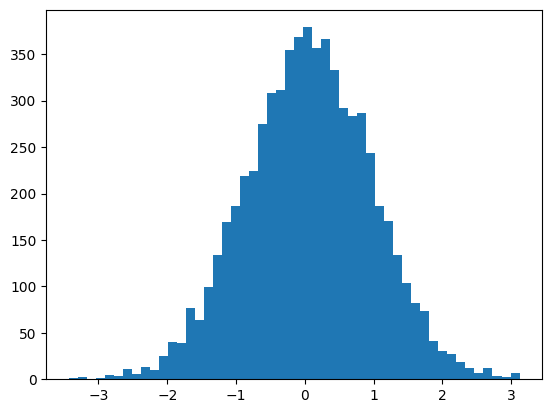

In [91]:
# Distribution of values before the tanh function, when theay are too big or too small, the tanh function will return 1 or -1
# it will lead to a dead neuron
# That's why is important to have a good initialization of the weights
plt.hist(hpreact.view(-1).tolist(), bins=50);

In [ ]:
@torch.no_grad()
def print_results(split):
    X, Y = {'Train': (Xtr, Ytr),
            'Dev': (Xdev, Ydev),
            'Test': (Xte, Yte)}[split]
    #forward pass
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split} | loss = {loss}")

print_results('Train')
print_results('Dev')
print_results('Test')

Train | loss = 3.0406150817871094
Dev | loss = 3.0377602577209473
Test | loss = 3.042259454727173


In [ ]:
#Model starting with a high loss

#Train | loss = 2.319223642349243
#Dev | loss = 2.3185811042785645
#Test | loss = 2.315457344055176

#Model with smaller w2 and b2
#Train | loss = 2.306452512741089
#Dev | loss = 2.3043744564056396
#Test | loss = 2.304983139038086

#Model reapiring h

In [ ]:
g = torch.Generator().manual_seed(2147483647 +20)
block_size = 3

for _ in range(20):

    out = []
    context = block_size * [0]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim = 1)
        ix = torch.multinomial(prob, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

zeipjyaa.
frlena.
we.
nnazg.
oanoxqragy.
eeotjnaa.
.
yzaanrplnanvawa.
oalniavslfaeee.
naaurraaean.
.
jcoyeaaan.
aaapnakaj.
a.
nnnnieapeaznqeh.
exazqennaqe.
pangaanzlaona.
.
ab.
caa.
